In [13]:
#!pip3 install pytorch-transformers==1.0.0

In [14]:
#!pip3 install boto3

In [15]:
# NOTE: This is specific to Google Colab to change the working directory. Use this to point to the path that contains Sarcasm_Headlines_Dataset.json file.
from google.colab import drive 
drive.mount('/content/drive')
%cd /content/drive/My\ Drive/Colab\ Notebooks

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks


In [16]:
!pwd

/content/drive/My Drive/Colab Notebooks


In [17]:
import random
import numpy as np
import os
import torch
import torch.nn as nn
from pytorch_transformers import BertModel, BertTokenizer, BertConfig, WarmupLinearSchedule
import re
import pandas as pd
import json
from torch.utils.data import Dataset
from torch.utils.data import DataLoader, SubsetRandomSampler
from tqdm import tqdm, trange

def seed_everything(seed = 42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

# For reproducible results
seed_everything()

In [18]:
# Constants

SEP_TOKEN = '[SEP]'
CLS_TOKEN = '[CLS]'
TRAIN_FILE_PATH = 'Sarcasm_Headlines_Dataset.json'
MAX_SEQ_LENGTH = 512
BATCH_SIZE = 4
NUM_EPOCHS = 6
GRADIENT_ACCUMULATION_STEPS = 8
WARMUP_STEPS = 3
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(DEVICE)

cuda:0


In [19]:
class BertClassifier(nn.Module):

    def __init__(self, config):
        super(BertClassifier, self).__init__()
        # Binary classification problem (num_labels = 2)
        self.num_labels = config.num_labels
        # Pre-trained BERT model
        self.bert = BertModel(config)
        # Dropout to avoid overfitting
        self.dropout = nn.Dropout(config.hidden_dropout_prob)
        # A single layer classifier added on top of BERT to fine tune for binary classification
        self.classifier = nn.Linear(config.hidden_size, config.num_labels)
        # Weight initialization
        torch.nn.init.xavier_normal_(self.classifier.weight)

    def forward(self, input_ids, token_type_ids=None, attention_mask=None,
                position_ids=None, head_mask=None):
        # Forward pass through pre-trained BERT
        outputs = self.bert(input_ids, position_ids=position_ids, token_type_ids=token_type_ids,
                            attention_mask=attention_mask, head_mask=head_mask)
        
        # Last layer output (Total 12 layers)
        pooled_output = outputs[-1]
        pooled_output = pooled_output.detach()   # Stop gradient to prevent bert encoder from being fine-tuned

        pooled_output = self.dropout(pooled_output)
        return self.classifier(pooled_output)

In [20]:
class SequenceDataset(Dataset):
    def __init__(self, dataset_file_path, tokenizer, regex_transformations={}):
        # Read JSON file and assign to headlines variable (list of strings)
        df = pd.read_json(dataset_file_path, lines=True)
        print (df)
        df = df.drop(['article_link'], axis=1)
        self.headlines = df.values
        # Regex Transformations can be used for data cleansing.
        # e.g. replace 
        #   '\n' -> ' ', 
        #   'wasn't -> was not
        self.regex_transformations = regex_transformations
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.headlines)

    def __getitem__(self, index):
        headline, is_sarcastic = self.headlines[index]
        for regex, value_to_replace_with in self.regex_transformations.items():
            headline = re.sub(regex, value_to_replace_with, headline)

        # Convert input string into tokens with the special BERT Tokenizer which can handle out-of-vocabulary words using subgrams
        # e.g. headline = Here is the sentence I want embeddings for.
        #      tokens = [here, is, the, sentence, i, want, em, ##bed, ##ding, ##s, for, .]
        tokens = self.tokenizer.tokenize(headline)

        # Add [CLS] at the beginning and [SEP] at the end of the tokens list for classification problems
        tokens = [CLS_TOKEN] + tokens + [SEP_TOKEN]
        # Convert tokens to respective IDs from the vocabulary
        input_ids = self.tokenizer.convert_tokens_to_ids(tokens)

        # Segment ID for a single sequence in case of classification is 0. 
        segment_ids = [0] * len(input_ids)

        # Input mask where each valid token has mask = 1 and padding has mask = 0
        input_mask = [1] * len(input_ids)

        # padding_length is calculated to reach max_seq_length
        padding_length = MAX_SEQ_LENGTH - len(input_ids)
        input_ids = input_ids + [0] * padding_length
        input_mask = input_mask + [0] * padding_length
        segment_ids = segment_ids + [0] * padding_length

        assert len(input_ids) == MAX_SEQ_LENGTH
        assert len(input_mask) == MAX_SEQ_LENGTH
        assert len(segment_ids) == MAX_SEQ_LENGTH

        return torch.tensor(input_ids, dtype=torch.long, device=DEVICE), \
               torch.tensor(segment_ids, dtype=torch.long, device=DEVICE), \
               torch.tensor(input_mask, device=DEVICE), \
               torch.tensor(is_sarcastic, dtype=torch.long, device=DEVICE)

In [21]:
# Load BERT default config object and make necessary changes as per requirement
config = BertConfig(hidden_size=768,
                    num_hidden_layers=12,
                    num_attention_heads=12,
                    intermediate_size=3072,
                    num_labels=2)

# Create our custom BERTClassifier model object
model = BertClassifier(config)
model.to(DEVICE)

# Initialize BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [22]:
#train_dataset

In [23]:
# Load Train dataset and split it into Train and Validation dataset
train_dataset = SequenceDataset(TRAIN_FILE_PATH, tokenizer)

validation_split = 0.4

dataset_size = len(train_dataset)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
shuffle_dataset = True

if shuffle_dataset :
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
validation_sampler = SubsetRandomSampler(val_indices)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=validation_sampler)

print ('Training Set Size {}, Validation Set Size {}'.format(len(train_indices), len(val_indices)))

                                           article_link  \
0     https://www.huffingtonpost.com/entry/versace-b...   
1     https://www.huffingtonpost.com/entry/roseanne-...   
2     https://local.theonion.com/mom-starting-to-fea...   
3     https://politics.theonion.com/boehner-just-wan...   
4     https://www.huffingtonpost.com/entry/jk-rowlin...   
...                                                 ...   
2994  https://www.huffingtonpost.com/entry/military-...   
2995  https://www.huffingtonpost.com/entry/trump-adm...   
2996  https://www.huffingtonpost.com/entry/we-found-...   
2997  https://www.huffingtonpost.com/entry/what-if-e...   
2998  https://www.theonion.com/bird-has-big-plans-fo...   

                                               headline  is_sarcastic  
0     former versace store clerk sues over secret 'b...             0  
1     the 'roseanne' revival catches up to our thorn...             0  
2     mom starting to fear son's web series closest ...             1  
3  

In [36]:
# Loss Function
criterion = nn.CrossEntropyLoss()

# Adam Optimizer with very small learning rate given to BERT
optimizer = torch.optim.Adam([
                #{'params': model.bert.parameters(), 'lr' : 1e-5},
                {'params': model.classifier.parameters(), 'lr': 5e-5}
            ])

# Learning rate scheduler
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=WARMUP_STEPS, t_total=len(train_loader) // GRADIENT_ACCUMULATION_STEPS * NUM_EPOCHS)

model.zero_grad()
epoch_iterator = trange(int(NUM_EPOCHS), desc="Epoch")
training_acc_list, validation_acc_list = [], []

for epoch in epoch_iterator:
    epoch_loss = 0.0
    train_correct_total = 0

    # Training Loop
    train_iterator = tqdm(train_loader, desc="Train Iteration")
    for step, batch in enumerate(train_iterator):
        model.train(True)
        # Here each element of batch list refers to one of [input_ids, segment_ids, attention_mask, labels]
        inputs = {
            'input_ids': batch[0].to(DEVICE),
            'token_type_ids': batch[1].to(DEVICE),
            'attention_mask': batch[2].to(DEVICE)
        }

        labels = batch[3].to(DEVICE)
        logits = model(**inputs)

        loss = criterion(logits, labels) / GRADIENT_ACCUMULATION_STEPS
        loss.backward()
        epoch_loss += loss.item()

        if (step + 1) % GRADIENT_ACCUMULATION_STEPS == 0:
            scheduler.step()
            optimizer.step()
            model.zero_grad()

        _, predicted = torch.max(logits.data, 1)
        correct_reviews_in_batch = (predicted == labels).sum().item()
        train_correct_total += correct_reviews_in_batch
    
    print('Epoch {} - Loss {:.2f}'.format(epoch + 1, epoch_loss / len(train_indices)))

    # Validation Loop
    with torch.no_grad():
        val_correct_total = 0
        model.train(False)
        val_iterator = tqdm(val_loader, desc="Validation Iteration")
        for step, batch in enumerate(val_iterator):
            inputs = {
                'input_ids': batch[0].to(DEVICE),
                'token_type_ids': batch[1].to(DEVICE),
                'attention_mask': batch[2].to(DEVICE)
            }

            labels = batch[3].to(DEVICE)
            logits = model(**inputs)

            _, predicted = torch.max(logits.data, 1)
            correct_reviews_in_batch = (predicted == labels).sum().item()
            val_correct_total += correct_reviews_in_batch

        training_acc_list.append(train_correct_total * 100 / len(train_indices))
        validation_acc_list.append(val_correct_total * 100 / len(val_indices))
        print('Training Accuracy {:.4f} - Validation Accurracy {:.4f}'.format(train_correct_total * 100 / len(train_indices), val_correct_total * 100 / len(val_indices)))

Train Iteration: 100%|██████████| 450/450 [01:14<00:00,  6.03it/s]


Epoch 1 - Loss 0.03



Epoch:  17%|█▋        | 1/6 [02:01<10:09, 121.84s/it]

Training Accuracy 57.1111 - Validation Accurracy 67.3061



Train Iteration: 100%|██████████| 450/450 [01:14<00:00,  6.03it/s]


Epoch 2 - Loss 0.03



Epoch:  33%|███▎      | 2/6 [04:03<08:07, 121.98s/it]

Training Accuracy 56.3889 - Validation Accurracy 67.2227



Train Iteration: 100%|██████████| 450/450 [01:14<00:00,  6.00it/s]


Epoch 3 - Loss 0.03



Epoch:  50%|█████     | 3/6 [06:06<06:06, 122.17s/it]

Training Accuracy 55.8333 - Validation Accurracy 67.2227



Train Iteration: 100%|██████████| 450/450 [01:14<00:00,  6.02it/s]


Epoch 4 - Loss 0.02



Epoch:  67%|██████▋   | 4/6 [08:08<04:04, 122.23s/it]

Training Accuracy 57.5556 - Validation Accurracy 67.8065



Train Iteration: 100%|██████████| 450/450 [01:14<00:00,  6.04it/s]


Epoch 5 - Loss 0.03



Epoch:  83%|████████▎ | 5/6 [10:10<02:02, 122.26s/it]

Training Accuracy 56.3333 - Validation Accurracy 67.4729



Train Iteration: 100%|██████████| 450/450 [01:14<00:00,  6.04it/s]


Epoch 6 - Loss 0.02



Epoch: 100%|██████████| 6/6 [12:13<00:00, 122.17s/it]

Training Accuracy 58.3333 - Validation Accurracy 67.5563


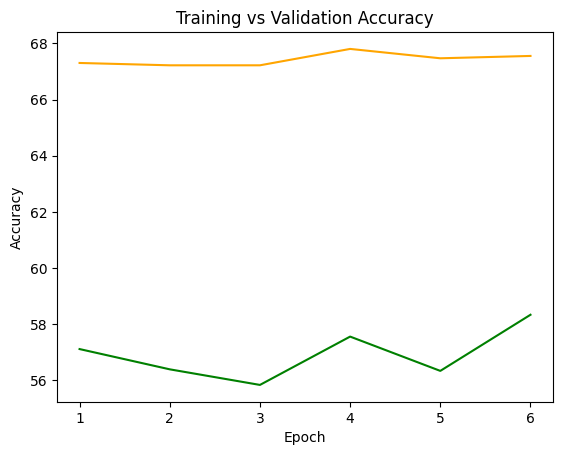

In [37]:
import matplotlib.pyplot as plt

epochs_list = list(range(1, NUM_EPOCHS + 1))
plt.plot(epochs_list, training_acc_list, color='g')
plt.plot(epochs_list, validation_acc_list, color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.show()

In [38]:
train_correct_total * 100 / len(train_indices)

58.333333333333336